In [1]:
# basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import json
import math
import seaborn as sns
import ast
from collections import Counter
import networkx as nx

# stats imports
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import f_oneway
from scipy.stats import boxcox
from scipy.stats import pearsonr, spearmanr
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import boxcox
import pmdarima as pm

# regression imports
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import mixedlm

# src imports
from src.utils import cleaning
#from src.utils import tokenization
from src.utils import filling
from src.utils import cluster_search
from src.data.continents_clusters import regions

# Data loading

In [2]:
# data path
DATA = './src/data/'

# movie metadata loading
df_movies = pd.read_csv(DATA + 'movie.metadata.tsv', sep='\t', header=None)
df_movies.columns = ['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue', 
                     'runtime', 'spoken_languages', 'countries', 'genres']

# charcaters metadata loading
df_characters = pd.read_csv(DATA + 'character.metadata.tsv', sep='\t', header=None)
df_characters.columns = ['wikipedia_id', 'freebase_id', 'release_date', 'character_name', 'actor_birth',
                     'actor_gender', 'actor_height', 'actor_ethnicity', 'actor_name', 
                     'age_at_release', 'freebase_map', 'freebase_character_id', 'freebase_actor_id']

# plot summaries loading
df_plots = pd.read_csv(DATA + 'plot_summaries.txt', sep='\t', header=None, names=['wikipedia_id', 'plot_summary'])

# TMDB dataset loading
df_tmdb = pd.read_csv(DATA + 'TMDB_movie_dataset_v11.csv')

# ratings datasets loading
df_ratings_link = pd.read_csv(DATA + 'ratings_links.csv', sep=',')
df_ratings_ratings = pd.read_csv(DATA + 'ratings_ratings.csv', sep=',')
df_ratings_imdb = pd.read_csv(DATA + 'title.ratings.tsv', sep='\t')

For now, the plots dataset `df_plots` does not require any cleaning operation, as the dataset presents 0% missing values in its columns with no particular format to standardize. However, the movies and characters dataset do require significant cleaning, as is presented below.

# Movies dataset wrangling

Duplicate movies exist in the movies dataset and are first considered.

In [3]:
# df_movies has duplicates of the same movies based on their title which we will delete, only 5% of all data
df_movies = df_movies.drop_duplicates(subset=['title'])

In [4]:
# the df_tmdb dataframe has many duplicates for titles but these could be movies with the same title that are different or movies that are the same
# but are different in features on these movies
df_tmdb = df_tmdb.drop_duplicates(subset=['imdb_id'])

In [5]:
# Altering the release date feature in the TMDB dataframe and in the moves dataframe to match, for unique index creation

# drop movies in each dataframe with missing release dates 
df_movies = df_movies.dropna(subset=['release_date'])
df_tmdb = df_tmdb.dropna(subset=['release_date'])
df_movies['release_date'] = df_movies['release_date'].apply(cleaning.clean_dates)
df_tmdb['release_date'] = df_tmdb['release_date'].apply(cleaning.clean_dates)

title_release_movies = df_movies.title + df_movies.release_date.astype(str)
df_movies_copy = df_movies.copy()
df_movies_copy.index = title_release_movies

title_release_tmdb = df_tmdb.title + df_tmdb.release_date.astype(str)
df_tmdb_copy = df_tmdb.copy()
df_tmdb_copy.index = title_release_tmdb

df_movies_tmdb = pd.merge(df_movies_copy, df_tmdb_copy, left_index=True, right_index=True)

# as the unique index of title and release date was used to merge the dataframes, the original title columns are duplicated and must be removed
df_movies_tmdb = df_movies_tmdb.drop(['title_y'], axis = 1).rename(columns={'title_x': 'title'}) 

In [6]:
# drop some duplicate columns and then rename
df_movies_tmdb = df_movies_tmdb.drop(['spoken_languages_y'], axis = 1).rename(columns={'spoken_languages_x': 'spoken_languages'}) 
df_movies_tmdb = df_movies_tmdb.drop(['genres_y'], axis = 1).rename(columns={'genres_x': 'genres'}) 

In [7]:
# cleaning 'spoken_languages', 'countries', 'genres' df_movies columns in df_movies_tmdb
df_movies_tmdb['spoken_languages'] = df_movies_tmdb['spoken_languages'].apply(cleaning.clean_idxs)
df_movies_tmdb['countries'] = df_movies_tmdb['countries'].apply(cleaning.clean_idxs)
df_movies_tmdb['genres'] = df_movies_tmdb['genres'].apply(cleaning.clean_idxs)

In [8]:
# use the release date of the TMDB dataset to fill the release date of a movie if not present in CMU dataset
df_movies_tmdb['release_date_x'] = df_movies_tmdb['release_date_x'].fillna(df_movies_tmdb['release_date_y'])

# drop missing release dates, remove duplicate column and rename release_date_x
df_movies_tmdb = df_movies_tmdb.dropna(subset=['release_date_x'])
df_movies_tmdb = df_movies_tmdb.drop(['release_date_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'release_date_x': "release_date"}) 

# filter dates to meaningful ones by keeping the release interval [1888, 2012], since 
# the very first movie was released in 1888 and meaningful data from df_movies is up to 2012
df_movies_tmdb = cleaning.filter_years(df_movies_tmdb, 'release_date')

In [9]:
# use the revenues of the TMDB dataset to fill the revenues of a movie if not present in CMU dataset
df_movies_tmdb['revenue_x'] = df_movies_tmdb['revenue_x'].fillna(df_movies_tmdb['revenue_y'])

# remove duplicate column and rename revenue_x
df_movies_tmdb = df_movies_tmdb.drop(['revenue_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'revenue_x': "revenue"}) 

In [10]:
# use the runtimes of the TMDB dataset to fill the runtimes of a movie if not present in CMU dataset
df_movies_tmdb['runtime_x'] = df_movies_tmdb['runtime_x'].fillna(df_movies_tmdb['runtime_y'])

# remove duplicate column and rename runtime_x
df_movies_tmdb = df_movies_tmdb.drop(['runtime_y'], axis = 1)
df_movies_tmdb = df_movies_tmdb.rename(columns={'runtime_x': "runtime"}) 

In [11]:
# remove movies with no genre reported
df_movies_tmdb = df_movies_tmdb.dropna(subset=['genres'])

In [12]:
# dropping movies that have missing IMDB IDs
df_movies_tmdb = df_movies_tmdb.dropna(subset=["imdb_id"])
df_movies_tmdb = df_movies_tmdb.drop(df_movies_tmdb[df_movies_tmdb["imdb_id"] == 'nan'].index)

# IMDB references in df_movies_tmdb are formatted differently than in df_ratings_link
df_movies_tmdb['imdb_id'] = df_movies_tmdb['imdb_id'].apply(cleaning.clean_imdb)

In [13]:
# IMDB references in df_ratings_imdb_id are formatted differently than in df_movies_tmdb
df_ratings_imdb['tconst'] = df_ratings_imdb['tconst'].apply(cleaning.clean_imdb)

# giving movie metadata ratings from imdb mean ratings using tmdb as linker as it has imdb ids of movies
df_movies_ratings_imdb = pd.merge(df_movies_tmdb, df_ratings_imdb, left_on='imdb_id', right_on='tconst')

In [14]:
# dropping many useless columns
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['id'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['status'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['vote_average'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['vote_count'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['backdrop_path'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['homepage'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['original_title'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['overview'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['popularity'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['poster_path'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['tagline'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['keywords'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['tconst'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['adult'], axis = 1)
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['production_countries'], axis = 1)

In [15]:
# replacing the runtime outliers with mean of non-outliers, assuming normality, apply +/- t*IQR of quantiles method
df_movies_ratings_imdb = filling.fill_iqr(df_movies_ratings_imdb, 'runtime', 3.5)

In [16]:
# Dropping missing 'countries' entries
df_movies_ratings_imdb.dropna(subset=['countries'], inplace=True)

# Evaluating movies with more than one country
df_movies_ratings_imdb['country_count'] = df_movies_ratings_imdb['countries'].str.len()
movies_1_country = df_movies_ratings_imdb[df_movies_ratings_imdb['country_count'] == 1.0]
movies_1_or_2_country = df_movies_ratings_imdb[(df_movies_ratings_imdb['country_count'] == 1.0) | (df_movies_ratings_imdb['country_count'] == 2.0)]

movies_1_country_size = movies_1_country.size
movies_1_or_2_country_size = movies_1_or_2_country.size
all_movies = df_movies_ratings_imdb.size

percent_one_country = movies_1_country_size/all_movies
percent_one_or_two_country = movies_1_or_2_country_size/all_movies

print(f"{percent_one_country} of our ratings-populated movie metadataset have only one country listed.")
print(f"{percent_one_or_two_country} of our ratings-populated movie metadataset have one or two countries listed.")

# Keeping movies with one country for further analysis
df_movies_ratings_imdb = movies_1_country
df_movies_ratings_imdb = df_movies_ratings_imdb.drop(['country_count'], axis = 1)

0.8652437957663759 of our ratings-populated movie metadataset have only one country listed.
0.9617624272111563 of our ratings-populated movie metadataset have one or two countries listed.


In [17]:
# Evaluating movies with more than one genre
df_movies_ratings_imdb['genre_count'] = df_movies_ratings_imdb['genres'].str.len()
movies_1_genre = df_movies_ratings_imdb[df_movies_ratings_imdb['genre_count'] == 1.0]
movies_1_or_2_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0)]
movies_1_to_3_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0)]
movies_1_to_4_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0) | (df_movies_ratings_imdb['genre_count'] == 4.0)]
movies_1_to_5_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0) | (df_movies_ratings_imdb['genre_count'] == 4.0) | (df_movies_ratings_imdb['genre_count'] == 5.0)]
movies_1_to_6_genre= df_movies_ratings_imdb[(df_movies_ratings_imdb['genre_count'] == 1.0) | (df_movies_ratings_imdb['genre_count'] == 2.0) | (df_movies_ratings_imdb['genre_count'] == 3.0) | (df_movies_ratings_imdb['genre_count'] == 4.0) | (df_movies_ratings_imdb['genre_count'] == 5.0) | (df_movies_ratings_imdb['genre_count'] == 6.0)]

movies_1_genre_size = movies_1_genre.size
movies_1_or_2_genre_size = movies_1_or_2_genre.size
movies_1_to_3_genre_size = movies_1_to_3_genre.size
movies_1_to_4_genre_size = movies_1_to_4_genre.size
movies_1_to_5_genre_size = movies_1_to_5_genre.size
movies_1_to_6_genre_size = movies_1_to_6_genre.size
all_movies = df_movies_ratings_imdb.size

percent_one_genre = movies_1_genre_size/all_movies
percent_one_or_two_genre = movies_1_or_2_genre_size/all_movies
percent_one_to_three_genre = movies_1_to_3_genre_size/all_movies
percent_one_to_four_genre = movies_1_to_4_genre_size/all_movies
percent_one_to_five_genre = movies_1_to_5_genre_size/all_movies
percent_one_to_six_genre = movies_1_to_6_genre_size/all_movies

print(f"{percent_one_genre} of our ratings-populated movie metadataset have only one genre listed.")
print(f"{percent_one_or_two_genre} of our ratings-populated movie metadataset have one or two genres listed.")
print(f"{percent_one_to_three_genre} of our ratings-populated movie metadataset have one to three genres listed.")
print(f"{percent_one_to_four_genre} of our ratings-populated movie metadataset have one to four genres listed.")
print(f"{percent_one_to_five_genre} of our ratings-populated movie metadataset have one to five genres listed.")
print(f"{percent_one_to_six_genre} of our ratings-populated movie metadataset have one to six genres listed.")

0.19834782357528669 of our ratings-populated movie metadataset have only one genre listed.
0.3923919008694145 of our ratings-populated movie metadataset have one or two genres listed.
0.5690188036163022 of our ratings-populated movie metadataset have one to three genres listed.
0.720169839114988 of our ratings-populated movie metadataset have one to four genres listed.
0.8306808006701135 of our ratings-populated movie metadataset have one to five genres listed.
0.9043066347014818 of our ratings-populated movie metadataset have one to six genres listed.


In [18]:
df_movies_ratings_imdb = df_movies_ratings_imdb.explode("genres")

# the genres column needs cleaning to ensure the same genres aren't doubled in a different format
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].map(str)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.lower()

df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace(" film", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace(" movies", "")

df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].map(str)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace("[", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace("]", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace("'", "")
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.replace('"', "")

# identifying the 20 most common single genres over all movies
genre_counts = df_movies_ratings_imdb['genres'].value_counts()

# getting the top 20 genres as a list
top_20_genres = genre_counts.head(20).index.tolist()

# removing irrelevant genre rows from the movies metadataset
df_movies_ratings_imdb = df_movies_ratings_imdb[df_movies_ratings_imdb['genres'].isin(top_20_genres)]

# the spoken languages, countries and genres columns needs to quickly be cleaned
df_movies_ratings_imdb["spoken_languages"] = df_movies_ratings_imdb["spoken_languages"].apply(lambda x: ",".join(map(str, x))  if type(x) == list else x)
df_movies_ratings_imdb["countries"] = df_movies_ratings_imdb["countries"].apply(lambda x: ",".join(map(str, x))  if type(x) == list else x)
df_movies_ratings_imdb["genres"] = df_movies_ratings_imdb["genres"].str.capitalize()

In [19]:
df_movies_tmdb_ratings = df_movies_ratings_imdb.copy()

# final ordering of the standard dataframe
df_movies_tmdb_ratings = df_movies_tmdb_ratings.sort_values(by='title')

# in the 'revenue' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['revenue'] = df_movies_tmdb_ratings['revenue'].replace(0.0, None)

# convert 'revenue' column to numeric values, raise error message in case of problems
df_movies_tmdb_ratings['revenue'] = pd.to_numeric(df_movies_tmdb_ratings['revenue'], errors='coerce')

In [20]:
# in the 'budget' column, substitute 0.0 with nan for clarity
df_movies_tmdb_ratings['budget'] = df_movies_tmdb_ratings['budget'].replace(0.0, None)

In [21]:
unique_titles_now = len(df_movies_tmdb_ratings['title'].unique())
unique_titles_before = len(df_movies)
print(f"There are now {unique_titles_now} unique movies in the standard movies dataset.")
print(f"There were {unique_titles_before} unique movies in the initial movies dataset.")

There are now 32977 unique movies in the standard movies dataset.
There were 68978 unique movies in the initial movies dataset.


### Adding `region` Column to the Master Dataframe

In [22]:
# dictionary to map each country to a continent
country_to_region = {}
for region, countries in regions.items():
    for country in countries:
        country_to_region[country] = region

# Map the 'countries' column to the 'region' column
df_movies_tmdb_ratings['region'] = df_movies_tmdb_ratings['countries'].map(country_to_region)

# since df_movies_tmdb_ratings[df_movies_tmdb_ratings['continent'].isna()] shows that 2 entries
# have not been assigned to a continent, a quick check allows to see that this is due to an error 
# in the country (the specific movie is 'The Flying Scotsman'). These entries are therefore dropped
df_movies_tmdb_ratings = df_movies_tmdb_ratings.dropna(subset=['region'])

In [23]:
df_movies_tmdb_ratings.columns

Index(['wikipedia_id', 'freebase_id', 'title', 'release_date', 'revenue',
       'runtime', 'spoken_languages', 'countries', 'genres', 'budget',
       'imdb_id', 'original_language', 'production_companies', 'averageRating',
       'numVotes', 'genre_count', 'region'],
      dtype='object')

# Unique Dataframe: 

In [24]:
# checking for nb of duplicate movies due to genre explosion
duplicates = df_movies_tmdb_ratings[df_movies_tmdb_ratings.duplicated(subset=['title'], keep=False)] #same as wikipedia_id
num_duplicates = len(duplicates)
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 67498


Due to the genre explosion, we have many duplicate movies. To better assess the new features and their effects on ratings independently of genres, we chose to maintain a unique DataFrame with single entries per movie, based on the `title` . 

In [25]:
df_movies_tmdb_ratings_unique = cleaning.drop_most_missing(df_movies_tmdb_ratings, ['title'])

# drop 'missing_values' column of df_movies_tmdb_ratings
#df_movies_tmdb_ratings = df_movies_tmdb_ratings.drop(columns=['missing_values'])

# dropping duplicates (just in case there are any duplicates after the selection process)
df_movies_tmdb_ratings_unique = df_movies_tmdb_ratings_unique.drop_duplicates(subset='title')

# Characters Dataset Cleaning

Analogous to the movie metadata, the characters dataset must be wrangled.

In [26]:
# clean characters 'release_date' and 'actor_birth' to keep the release year only
df_characters['release_date'] = df_characters['release_date'].apply(cleaning.clean_dates)
df_characters['actor_birth'] = df_characters['actor_birth'].apply(cleaning.clean_dates)

The datastory will most focus on actor ethnicity, therefore particular attention is payed to the related columns in `df_characters`.

In [27]:
# counting the number of unique values in 'actor_ethnicity', excluding NaN
print(f"Number of unique ethnicities in 'actor_ethnicity': {df_characters['actor_ethnicity'].nunique(dropna=True)} \n")

# counting the number of NaN values in 'actor_ethnicity'
print(f"Number of NaN values in 'actor_ethnicity': {df_characters['actor_ethnicity'].isna().sum()}")

# total number of entries in 'actor_ethnicity' column
print(f"Total entries in 'actor_ethnicity': {len(df_characters['actor_ethnicity'])}")

# NaN entries proportion
nan_proportion_ethnicity = df_characters['actor_ethnicity'].isna().sum() / len(df_characters['actor_ethnicity'])
print(f"Proportion of NaN values in 'actor_ethnicity': {nan_proportion_ethnicity:.2%}")

Number of unique ethnicities in 'actor_ethnicity': 479 

Number of NaN values in 'actor_ethnicity': 344611
Total entries in 'actor_ethnicity': 450669
Proportion of NaN values in 'actor_ethnicity': 76.47%


In [28]:
# counting the number of unique actors who have a non-NaN ethnicity
print(f"Unique actors who have an ethnicity: {df_characters.dropna(subset=['actor_ethnicity'])['actor_name'].nunique()}")

# counting the number of unique actors in total
print(f"Total number of unique actors: {df_characters['actor_name'].nunique()} \n")

# counting the number of unique movies (using either 'freebase_id' or 'wikipedia_id')
print(f"Total number of unique movies: {df_characters['freebase_id'].nunique()}")

# counting the number of unique movies with at least one actor who has a specified ethnicity
print(f"Unique movies with at least one actor with ethnicity: {df_characters.dropna(subset=['actor_ethnicity'])['freebase_id'].nunique() }")

Unique actors who have an ethnicity: 8148
Total number of unique actors: 134078 

Total number of unique movies: 64330
Unique movies with at least one actor with ethnicity: 37958


Actors' ethnicities are in the format of Freebase IDs. To translate them, these unique IDs have been saved in a `.txt` file, which has been translated using `query.wikidata.org` by executing the following SPARQL request:

```sparql
SELECT DISTINCT ?freebase_id ?wikidata_id ?label WHERE {
  VALUES ?freebase_id {
    "/m/05bzpzx" "/m/064rb5l" "/m/01km_m" "/m/059v8" "/m/03b_13l" "/m/09c8kp" "/m/05ztd1" 
    "/m/04c28" "/m/03sk2" "/m/04jtjvt" "/m/03hjx6f" "/m/027936c" "/m/03nvq" "/m/03nz70" 
    "/m/01g3rx" "/m/02wz7j" "/m/04kdwcx" "/m/04_8lfc" "/m/033qt1" "/m/08j1fb" "/m/07wsyr" 
    "/m/06vb7b" "/m/012fh" "/m/0dm3xpw" "/m/09r2kh" "/m/02ry8mk" "/m/029q52" "/m/026d074" 
    "/m/013y54"
    # Add more IDs as needed
  }
  ?wikidata_id wdt:P646 ?freebase_id.
  ?wikidata_id rdfs:label ?label.
  FILTER(LANG(?label) = "en")
}

The creation of the `.txt` file is achieved by `src/data/freebase_to_batches.py` and the result is `src/data/unique_actor_ethnicities_batexhes.txt`. The outputs from query.wikidata.org have been saved in a .csv file (`freebaseids_labels.csv`)

In [29]:
# defining src/data/ path
SRC_DATA = './src/data/'

# reading the .csv and saving it to a dataframe
df_labels = pd.read_csv(SRC_DATA + 'freebaseids_label.csv')
df_labels.columns = ['freebase_id', 'wikipedia_id', 'label']  

# mapping dictionary definition
freebase_to_label = dict(zip(df_labels['freebase_id'], df_labels['label']))

# creating 'ethnicity_label' column where to map the freebse ethnicity Ids to the 
# corresponding labels
df_characters['ethnicity_label'] = df_characters['actor_ethnicity'].map(freebase_to_label)

In [30]:
# calculating the proportion of nans in 'ethnicity_label'
nan_proportion_label = df_characters['ethnicity_label'].isna().sum() / len(df_characters['ethnicity_label'])

# checking if any information have been lost during the ids-label translation
print(f"Proportion of NaN values in 'actor_ethnicity': {nan_proportion_ethnicity:.2%}")
print(f"Proportion of NaN values in 'ethnicity_label': {nan_proportion_label:.2%}")

Proportion of NaN values in 'actor_ethnicity': 76.47%
Proportion of NaN values in 'ethnicity_label': 77.17%


In [31]:
# printing some of the counts of unique values in 'ethnicity_label', excluding NaN
print("Unique values in 'ethnicity_label' and their counts:")
print(df_characters['ethnicity_label'].value_counts(dropna=True).head(10)) 

Unique values in 'ethnicity_label' and their counts:
ethnicity_label
Indians               16351
African Americans     10159
Jewish people         10121
English people         6165
Irish Americans        3857
Italian Americans      2956
White people           2307
White Americans        2250
Scottish Americans     2223
Irish people           1637
Name: count, dtype: int64


### Clustering Ethnicities & Adding Nationalities & Ethnicities from Wikidata:

In [32]:
# Load the dictionary from the .txt file
with open(SRC_DATA + "ethnicities_clusters.txt", "r") as file:
    ethnicities_clusters = ast.literal_eval(file.read())

In [33]:
#defining the ethnicity_to_clusters dictionary
ethnicity_to_clusters = {}
for cluster, labels in ethnicities_clusters.items():
    for label in labels:
        #checking if the label is already in the dictionary
        if label not in ethnicity_to_clusters:
            # init a new empty list
            ethnicity_to_clusters[label] = []
        # Add the cluster if not already in the list to avoid duplicates
        if cluster not in ethnicity_to_clusters[label]:
            ethnicity_to_clusters[label].append(cluster)

# Map each character's ethnicity to its unique clusters
df_characters['mapped_clusters'] = df_characters['ethnicity_label'].apply(
    lambda ethnicity: ethnicity_to_clusters.get(ethnicity, [])
)


In [34]:
# searching unique ethnicity labels where 'mapped_clusters' is missing
unmatched_ethnicities = df_characters[df_characters['mapped_clusters'].isna()]['ethnicity_label'].unique()

Since the labels are still incomplete for a large part, information from wikidata is adopted to enrich the `df_characters` dataframe. For each actor (using his freebase_id), a query has been requested to retrieve ethnicity or nationality if available. Everything is saved in `wikidata_actor_info.csv`.

In [35]:
# reading the .csv as a dataframe
df_wikidata = pd.read_csv(SRC_DATA + 'wikidata_actor_info.csv', sep=',')

# left merging df_characters and df_wikidata
df_characters = pd.merge(df_characters, df_wikidata, left_on="freebase_actor_id", right_on="freebaseID", how="left")

In [36]:
# Filling 'ethnicity_label', where necessary, with the new labels extracted from wikidata
# (either 'ethnicityLabel' or 'nationalityLabel' if the first is NaN or ambiguous)
def fill_ethnicity(row):
    if row['ethnicity_label'] in unmatched_ethnicities:
        # If the ethnicity is ambiguous, retrieve the nationality
        return row['nationalityLabel'] if pd.notna(row['nationalityLabel']) else (
            row['ethnicityLabel'] if pd.notna(row['ethnicityLabel']) else row['ethnicity_label'])
    else:
        # For non-ambiguous cases, retrieve the ethnicity label associated to it or fallback to nationality
        return row['ethnicity_label'] if pd.notna(row['ethnicity_label']) else (
            row['ethnicityLabel'] if pd.notna(row['ethnicityLabel']) else row['nationalityLabel']
        )

df_characters['ethnicity_label'] = df_characters.apply(fill_ethnicity, axis=1)

# printing the final results
print(f"Before filling, the proportion of NaN values in 'ethnicity_label' was: {nan_proportion_label:.2%}")

# re-computing the proportion of nan in 'ethnicity_labels'
nan_proportion_label = df_characters['ethnicity_label'].isna().sum() / len(df_characters['ethnicity_label'])
print(f"After filling, the proportion of NaN values in 'ethnicity_label' is: {nan_proportion_label:.2%}")


Before filling, the proportion of NaN values in 'ethnicity_label' was: 77.17%
After filling, the proportion of NaN values in 'ethnicity_label' is: 36.54%


The proportion of missing values in `'ethnicity_label'` has been halved through filling it with wikidata information. This allows to save a big part of the original dataframe when dropping nan values in the `'ethnicity_label'` column. Now, new ethnicities can be mapped to the clusters in `ethnicities_clusters.txt` file, after updating the latter. Note that, for simplicity, only the last updated version of this file is stored in `/src/data/`, therefore also in the first clustering this version has been adopted. 

In [37]:
new_ethnicity_to_clusters = {}
for cluster, labels in ethnicities_clusters.items():
    for label in labels:
        new_ethnicity_to_clusters.setdefault(label, []).append(cluster)

df_characters['mapped_clusters'] = df_characters['ethnicity_label'].apply(
    lambda ethnicity: list(set(new_ethnicity_to_clusters.get(ethnicity, [])))
)

In [38]:
# Identify unmatched ethnicity labels
unmatched_ethnicities = df_characters[df_characters['ethnicity_label'].apply(
    lambda ethnicity: ethnicity not in ethnicity_to_clusters
)]['ethnicity_label']

# Count occurrences of unmatched ethnicity labels
unmatched_ethnicities_counts = unmatched_ethnicities.value_counts()

# Print the total number of unique unmatched ethnicity labels
print(f"Number of unmatched ethnicity labels: {unmatched_ethnicities_counts.shape[0]}")

# Print unmatched ethnicity labels with their counts
print("Unmatched ethnicity labels and their counts:")
print(unmatched_ethnicities_counts)

Number of unmatched ethnicity labels: 6
Unmatched ethnicity labels and their counts:
ethnicity_label
مسح                        9
multiracial people         4
Q25589681                  4
Karay-a people             2
Bohemian People            1
peoples of the Caucasus    1
Name: count, dtype: int64


When clustering ethnicities, we encountered challenges with ambiguous or mixed ethnicities and nationalities. While we assigned most of them to specific categories, a small number remained unassigned. Due to their low occurrence, we chose to exclude these entries from our analysis.

In [39]:
# dropping useless columns
#["freebase_id", "character_name", "actor_birth", "actor_height", "freebase_map","actor_ethnicity" ,"freebaseID","actorLabel", "nationalityLabel"], inplace=True)
df_characters= df_characters.drop(['freebaseID'], axis = 1)
df_characters= df_characters.drop(['actorLabel'], axis = 1)
df_characters= df_characters.drop(['ethnicityLabel'], axis = 1)
df_characters= df_characters.drop(['nationalityLabel'], axis = 1)
df_characters= df_characters.drop(['ethnicity_label'], axis = 1)
df_characters= df_characters.drop(['freebase_character_id'], axis = 1)
df_characters= df_characters.drop(['freebase_map'], axis = 1)
df_characters= df_characters.drop(['actor_height'], axis = 1)
df_characters= df_characters.drop(['character_name'], axis = 1)
df_characters=df_characters.drop(['actor_ethnicity'], axis = 1)
df_characters=df_characters.drop(['freebase_id'], axis = 1)

In [40]:
#renaming mapped cluster column
df_characters = df_characters.rename(columns={'mapped_clusters': 'actor_ethnicity'})
df_characters.head()


,wikipedia_id,release_date,actor_birth,actor_gender,actor_name,age_at_release,freebase_actor_id,actor_ethnicity
0,975900,2001.0,1958.0,F,Wanda De Jesus,42.0,/m/03wcfv7,[North Americans]
1,975900,2001.0,1974.0,F,Natasha Henstridge,27.0,/m/0346l4,[North Americans]
2,975900,2001.0,1969.0,M,Ice Cube,32.0,/m/01vw26l,"[North Americans, South and Central African]"
3,975900,2001.0,1967.0,M,Jason Statham,33.0,/m/034hyc,[West European]
4,975900,2001.0,1977.0,F,Clea DuVall,23.0,/m/01y9xg,[North Americans]


- No dropping NA's for now as we will be investigating ethnicities and genders.

In [41]:
#deleting useless dfs
del df_labels
del df_wikidata
del unmatched_ethnicities
del unmatched_ethnicities_counts

# Begining of Analysis:

## Nb of actors: 

Since we're trying to assess diversity in movies, we start by looking at the nb of actors in a movie. 

In [42]:
# Adding nb of actors per movie:
# Unique actors per movie as each entry of df_characters is a character in the movie 
actors_per_movie = df_characters.groupby('wikipedia_id')['freebase_actor_id'].nunique()
# Map the count back to the original dataframe
df_movies_tmdb_ratings['nb_actors'] = df_movies_tmdb_ratings['wikipedia_id'].map(actors_per_movie)
#df_movies_tmdb_ratings.head(50)
actors_per_movie.head()

wikipedia_id
330      4
3217    11
3333    14
3746    15
3837    20
Name: freebase_actor_id, dtype: int64

In [43]:
df_nb_actors = df_movies_tmdb_ratings.dropna(subset=['averageRating', 'nb_actors'])
# basic stats
print(df_nb_actors[['averageRating', 'nb_actors']].describe())

       averageRating     nb_actors
count   70758.000000  70758.000000
mean        6.147722      8.273368
std         1.080890      5.395317
min         1.100000      0.000000
25%         5.600000      4.000000
50%         6.300000      8.000000
75%         6.900000     11.000000
max         9.500000    115.000000


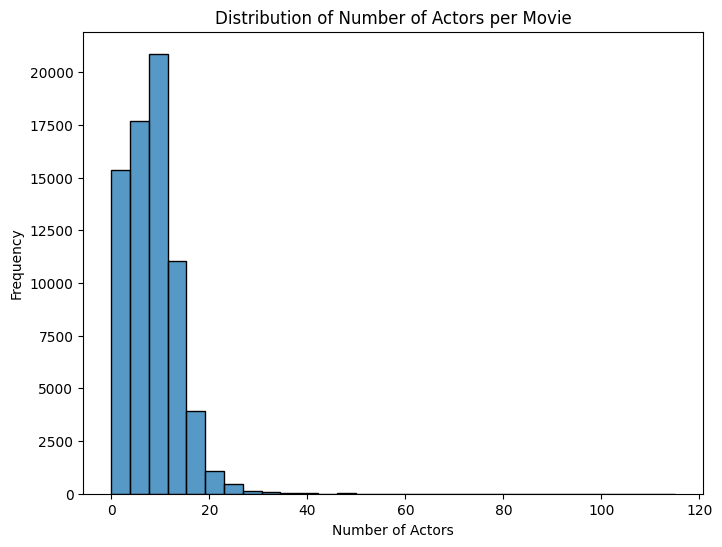

In [44]:
#Distribution of the number of actors
plt.figure(figsize=(8, 6))
sns.histplot(df_nb_actors['nb_actors'], bins=30, alpha=0.75, edgecolor='black')  # Histogram with KDE curve
plt.title("Distribution of Number of Actors per Movie")
plt.xlabel("Number of Actors")
plt.ylabel("Frequency")
plt.show()

In [45]:
# Calculate Pearson correlation
pearson_corr, pearson_p = pearsonr(df_nb_actors['averageRating'], df_nb_actors['nb_actors'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(df_nb_actors['averageRating'], df_nb_actors['nb_actors'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

Pearson correlation: 0.0355, p-value: 0.0000
Spearman correlation: 0.0343, p-value: 0.0000


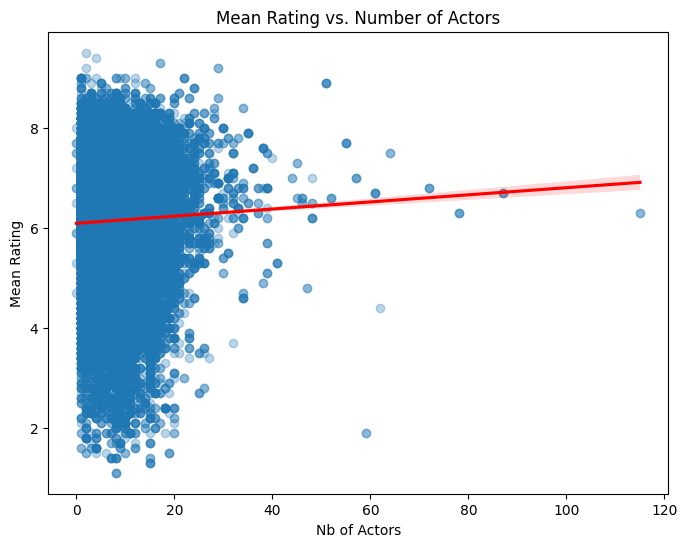

In [46]:
plt.figure(figsize=(8,6))
sns.regplot(
    x='nb_actors', 
    y='averageRating', 
    data=df_nb_actors, 
    scatter_kws={'alpha':0.3}, 
    line_kws={'color':'red'}
)
plt.xlabel('Nb of Actors')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Number of Actors')
plt.show()

Okay, after examining the number of actors per movie, let’s dig deeper into the demographics of the actors and explore how that might influence the ratings.

In [47]:
#creting new df merging character's data with master dataframe
df_movies_tmdb_ratings_characters = pd.merge(df_characters[['wikipedia_id','actor_gender','actor_ethnicity','freebase_actor_id']],
                             df_movies_tmdb_ratings_unique[['wikipedia_id','countries', 'title', 'release_date','genres','averageRating','region']], 
                             on='wikipedia_id', how='inner')


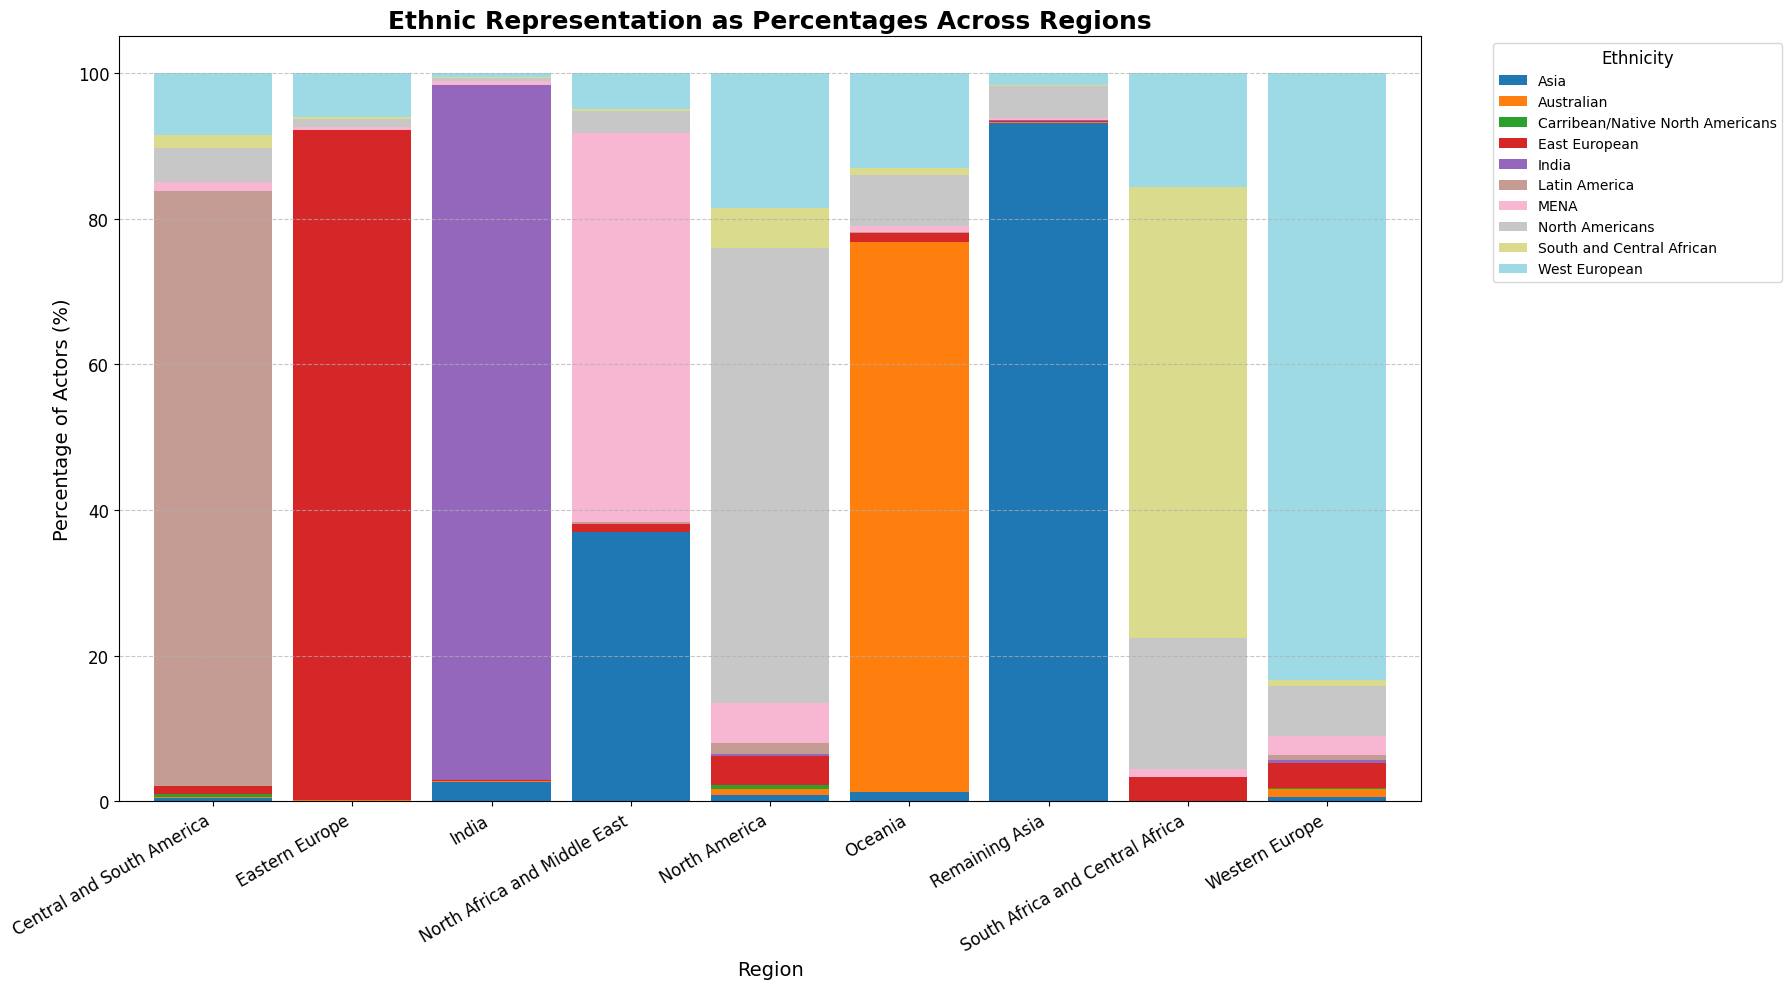

In [48]:
# Filter rows where both 'regions' and 'actor ethnicity' are not NaN
df_characters_region_ethnicity = df_movies_tmdb_ratings_characters.dropna(subset=['region', 'actor_ethnicity'])

# Explode the 'actor ethnicity' column to handle lists
df_characters_region_ethnicity_exploded = df_characters_region_ethnicity.explode('actor_ethnicity')

# Ethnicity representation by region
region_ethnicity_trends = df_characters_region_ethnicity_exploded.groupby(['region', 'actor_ethnicity']).size().unstack(fill_value=0)

# Calculate percentages for each region
region_ethnicity_percent = region_ethnicity_trends.div(region_ethnicity_trends.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart with percentages
plt.figure(figsize=(18, 10))  # Larger figure size for readability
region_ethnicity_percent.plot(kind='bar', stacked=True, colormap='tab20', width=0.85, ax=plt.gca())

# Labeling and layout improvements
plt.xlabel("Region", fontsize=14)
plt.ylabel("Percentage of Actors (%)", fontsize=14)
plt.title("Ethnic Representation as Percentages Across Regions", fontsize=18, fontweight='bold')

# Adjust x-tick rotation for readability
plt.xticks(rotation=30, ha="right", fontsize=12)

plt.yticks(fontsize=12)
plt.legend(title="Ethnicity", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


/var/folders/zw/3d22h42x67lctzjb8rx_3bdm0000gn/T/ipykernel_38432/911699761.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['region_category'] = df_clean.apply(


<Figure size 1800x1000 with 0 Axes>

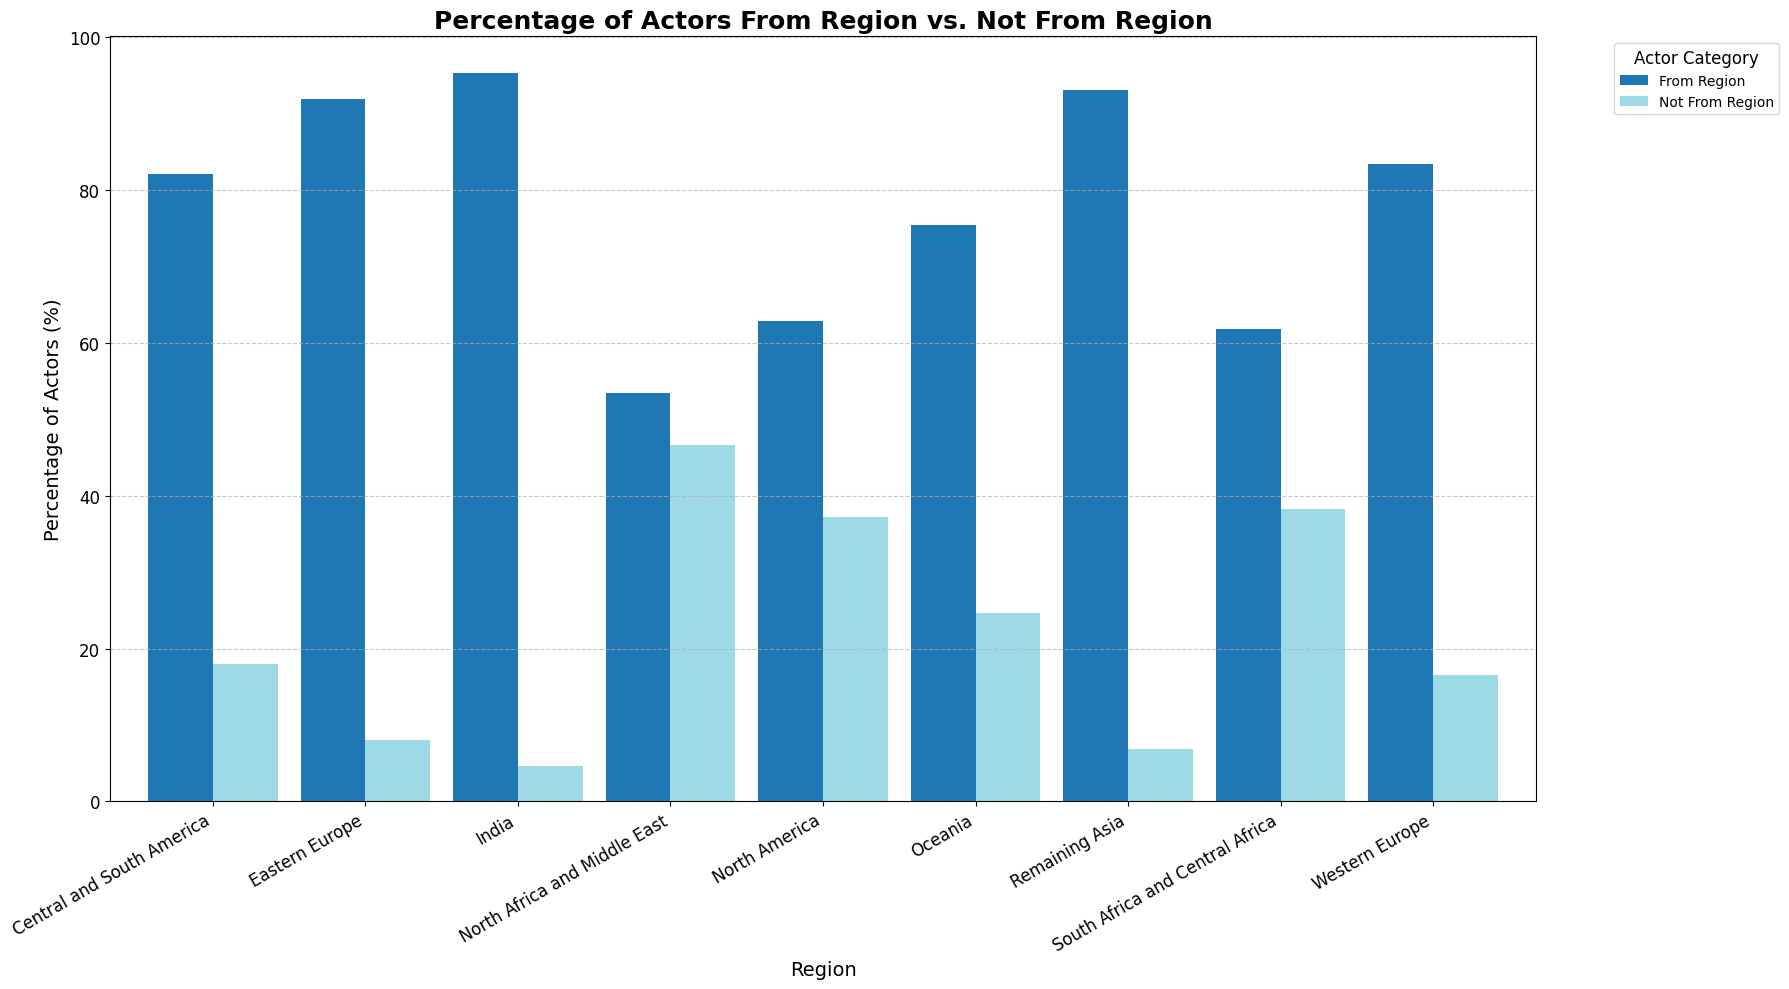

In [49]:
# Explode the 'actor_ethnicity' column to ensure one value per row
df_characters_region_ethnicity_exploded = df_characters_region_ethnicity.explode('actor_ethnicity')

# Map using the region_mapping dictionary
region_mapping = {
    'Asia': 'Remaining Asia',
    'Australian': 'Oceania',
    'Caribbean/Native North Americans': 'North America', 
    'Latin America': 'Central and South America',
    'East European': 'Eastern Europe',
    'India': 'India',
    'MENA': 'North Africa and Middle East',
    'North Americans': 'North America',
    'South and Central African': 'South Africa and Central Africa',
    'West European': 'Western Europe',

}

# Map the exploded ethnicity to standardized regions
df_characters_region_ethnicity_exploded['mapped_region'] = df_characters_region_ethnicity_exploded['actor_ethnicity'].map(region_mapping)

# Drop rows where mapping fails (unmatched regions)
df_clean = df_characters_region_ethnicity_exploded.dropna(subset=['mapped_region'])

# Classify as 'From Region' or 'Not From Region'
df_clean['region_category'] = df_clean.apply(
    lambda row: 'From Region' if row['region'] == row['mapped_region'] else 'Not From Region', axis=1
)

# Group by 'region' and 'region_category' to count actors
region_category_counts = df_clean.groupby(['region', 'region_category']).size().unstack(fill_value=0)

# Convert counts to percentages
region_category_percent = region_category_counts.div(region_category_counts.sum(axis=1), axis=0) * 100

# Plot grouped bar chart for From Region vs. Not From Region
plt.figure(figsize=(18, 10))

# Unstack the data to prepare for grouped bar plotting
region_category_counts_unstacked = region_category_percent.unstack().reset_index()
region_category_counts_unstacked.columns = ['Category', 'Region', 'Percentage']

# Pivot data to get Categories as columns (grouped bar structure)
grouped_data = region_category_counts_unstacked.pivot(index='Region', columns='Category', values='Percentage')

# Plot the grouped bar chart
grouped_data.plot(kind='bar', colormap='tab20', width=0.85, figsize=(18, 10))
 
plt.title("Percentage of Actors From Region vs. Not From Region", fontsize=18, fontweight='bold')
plt.xlabel("Region", fontsize=14)
plt.ylabel("Percentage of Actors (%)", fontsize=14)

plt.xticks(rotation=30, ha="right", fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title="Actor Category", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


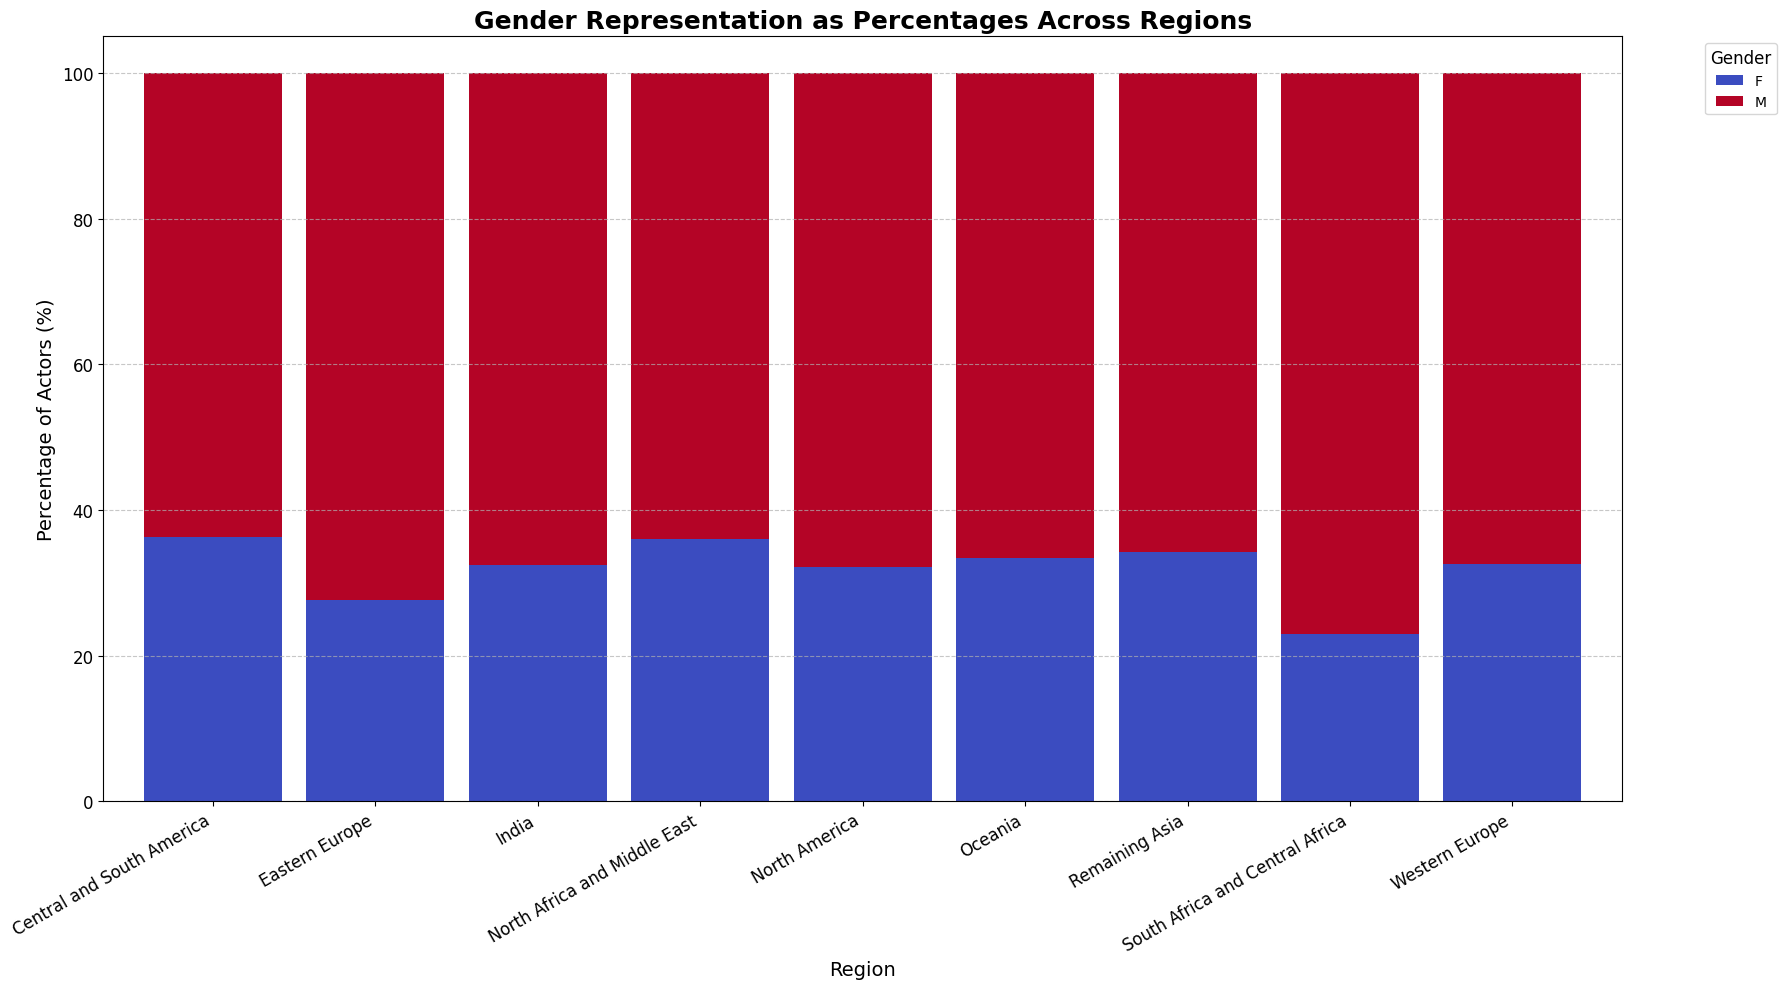

In [50]:
# Filter rows where both 'region' and 'actor_gender' are not NaN
df_characters_region_gender = df_movies_tmdb_ratings_characters.dropna(subset=['region', 'actor_gender'])

# Group by 'region' and 'actor_gender', then count occurrences
region_gender_trends = df_characters_region_gender.groupby(['region', 'actor_gender']).size().unstack(fill_value=0)

# Calculate percentages for each region
region_gender_percent = region_gender_trends.div(region_gender_trends.sum(axis=1), axis=0) * 100

# Plot the stacked bar chart with percentages
plt.figure(figsize=(18, 10))  # Larger figure size for readability
region_gender_percent.plot(kind='bar', stacked=True, colormap='coolwarm', width=0.85, ax=plt.gca())

# Labeling and layout improvements
plt.xlabel("Region", fontsize=14)
plt.ylabel("Percentage of Actors (%)", fontsize=14)
plt.title("Gender Representation as Percentages Across Regions", fontsize=18, fontweight='bold')

# Adjust x-tick rotation for readability
plt.xticks(rotation=30, ha="right", fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="Gender", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, title_fontsize=12)

# Optional: add horizontal grid lines for readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Improve layout
plt.tight_layout()
plt.show()


## Creating the Ethnicity score - using characters dataframe

What interests us is how the demographics of the cast members of one movie may impact it's ratings. We'll look at their ethnicities and their genders. This two features have to be quantified through an ethnicity_score and a gender_score per movie, reflecting not only the proportions but the distribution of the cast. A movie with 10 ethnicities represented equally (balanced distribution) should score higher in diversity than a movie with 10 ethnicities but dominated by one ethnicity. This is where the Shannon Diversity Index (SDI) becomes valuable because we are not capturing the true spread of diversity.
- **Shannon Index** offers a balanced measure of diversity, reducing the impact of outliers and providing a more accurate view of diversity distribution. We will be looking at the entropy of distribution. 
$$
H = - \sum_{i=1}^{n} p_i \ln(p_i)
$$

Where:

- \(H\): Shannon Diversity Index  
- \(p_i\): Proportion of individuals in the \(i\)-th category (ethnicity)  
- \(n\): Total number of categories (ethnicities)  




## 1-Ethnicity Score 

First we create a new dataframe which will contain the movie_id , number of characters of each movie , and proportion of individuals of each ethnicity in each movie, and finally the SDI ethnicity score for each movie. 

In [51]:
df_characters.shape

(480647, 8)

In [52]:
#filtering actors with no ethnicities by filtering nans and empty lists
df_filtered = df_characters[
    df_characters['actor_ethnicity'].notna() & df_characters['actor_ethnicity'].apply(lambda x: len(x) > 0)
]

In [53]:
df_filtered.shape 

(305000, 8)

In [54]:
#Df for ethnicity diversity score
df_ethnicity_exploded = df_filtered.explode('actor_ethnicity')

In [55]:
# Occurrences of each ethnicity per movie
ethnicity_counts = df_ethnicity_exploded.groupby(['wikipedia_id', 'actor_ethnicity']).size().reset_index(name='ethnicity_count')
# since df_ethnicity is exploded based on ethnicities, counting the nb of entries simply gives total nb of ethnicities in the movie
total_actors = df_ethnicity_exploded.groupby('wikipedia_id').size().reset_index(name='total_actors')
# Merge counts back into exploded dataframe
df_ethnicity_counts = ethnicity_counts.merge(total_actors, on='wikipedia_id')
# Proportions for each ethnicity
df_ethnicity_counts['ethnicity_proportion'] = df_ethnicity_counts['ethnicity_count'] / df_ethnicity_counts['total_actors']

df_ethnicity_counts.head(20) 


,wikipedia_id,actor_ethnicity,ethnicity_count,total_actors,ethnicity_proportion
0,330,West European,1,1,1.000000
1,3217,East European,1,13,0.076923
2,3217,North Americans,9,13,0.692308
3,3217,West European,3,13,0.230769
4,3333,North Americans,12,14,0.857143
5,3333,West European,2,14,0.142857
6,3746,Asia,1,12,0.083333
7,3746,Latin America,1,12,0.083333
8,3746,North Americans,8,12,0.666667
9,3746,West European,2,12,0.166667


In [56]:
def shannon_entropy(proportions):
    """
    Calculates the Shannon entropy given a list or series of proportions.
    
    Parameters:
    proportions (list or pd.Series): Proportions of categories in a group.
    
    Returns:
    float: Shannon entropy (diversity index).
    """
    return -np.sum(proportions * np.log(proportions))



In [57]:
# Calculate SDI for each movie
df_sdi = df_ethnicity_counts.groupby('wikipedia_id').apply(
    lambda group: shannon_entropy(group['ethnicity_proportion'])
).reset_index(name='SDI_ethnicity')

# Merge the SDI scores back to the original dataframe
df_ethnicity_counts = df_ethnicity_counts.merge(df_sdi, on='wikipedia_id')

#Drop duplicates for distribution analysis 
df_ethnicity_counts = df_ethnicity_counts.drop_duplicates(subset='wikipedia_id')

df_ethnicity_counts.head()


/var/folders/zw/3d22h42x67lctzjb8rx_3bdm0000gn/T/ipykernel_38432/2729616537.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sdi = df_ethnicity_counts.groupby('wikipedia_id').apply(


,wikipedia_id,actor_ethnicity,ethnicity_count,total_actors,ethnicity_proportion,SDI_ethnicity
0,330,West European,1,1,1.000000,-0.000000
1,3217,East European,1,13,0.076923,0.790268
4,3333,North Americans,12,14,0.857143,0.410116
6,3746,Asia,1,12,0.083333,0.983088
10,3837,East European,2,22,0.090909,1.236540


In [58]:
df_ethnicity_counts["SDI_ethnicity"].describe()

count    59557.000000
mean         0.392283
std          0.443042
min         -0.000000
25%          0.000000
50%          0.000000
75%          0.693147
max          1.858519
Name: SDI_ethnicity, dtype: float64

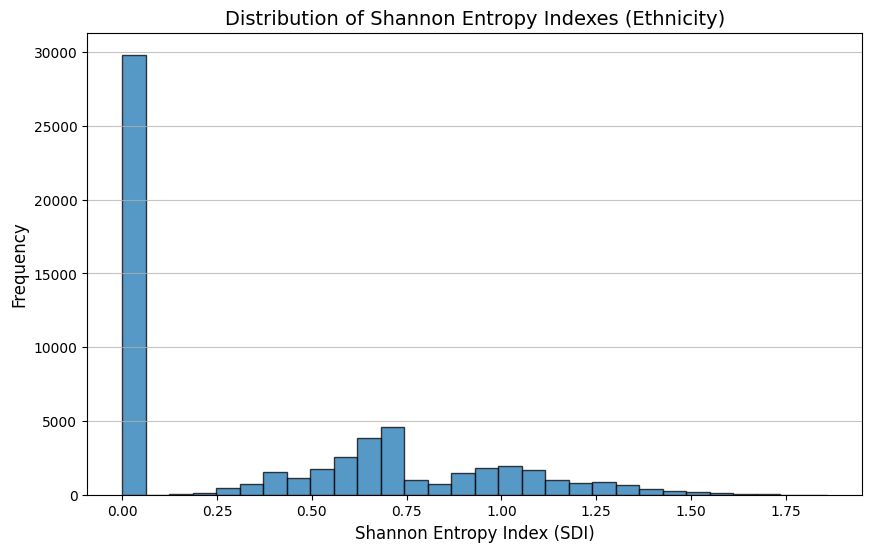

In [59]:
# Plot the distribution of Shannon entropy indexes
plt.figure(figsize=(10, 6))
plt.hist(df_ethnicity_counts['SDI_ethnicity'], bins=30, alpha=0.75, edgecolor='black')
plt.title('Distribution of Shannon Entropy Indexes (Ethnicity)', fontsize=14)
plt.xlabel('Shannon Entropy Index (SDI)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

The Shannon Entropy Index (SDI) for actors ethnicity in movies highlights a clear imbalance. From the summary statistics and distribution:

- Dominant Zero Values: A significant portion of the movies (over 50%) have an SDI of 0, meaning no ethnic diversity among the cast.
- Low Overall Mean (0.39): The average SDI remains low, indicating limited ethnic diversity across the dataset.
- Sparse Higher Values: A small subset of movies exhibit higher SDI values, reflecting greater ethnic diversity but occurring infrequently.

The distribution suggests that while some movies feature a diverse cast, the overall trend leans heavily toward minimal or no ethnic diversity. We'll have to dig deeper into that and see how it might affect ratings. 

## 2-Gender Score 

In [60]:
df_characters.shape

(480647, 8)

In [61]:
df_characters_gender = df_characters.dropna(subset=['actor_gender'])

df_characters_gender.shape

(433879, 8)

In [62]:
# For Gender Diversity Index (SDI)
# Ooccurrences of each gender per movie
gender_counts = df_characters_gender.groupby(['wikipedia_id', 'actor_gender']).size().reset_index(name='gender_count')
# Total number of actors per movie
total_actors_per_movie = df_characters_gender.groupby('wikipedia_id').size().reset_index(name='total_actors')
#Merge the counts back into a single dataframe
df_gender_counts = gender_counts.merge(total_actors_per_movie, on='wikipedia_id')
# Proportions for each gender
df_gender_counts['gender_proportion'] = df_gender_counts['gender_count'] / df_gender_counts['total_actors']

# Step 5: Calculate SDI for each movie
df_sdi_gender = df_gender_counts.groupby('wikipedia_id').apply(
    lambda group: shannon_entropy(group['gender_proportion'])
).reset_index(name='SDI_gender')

# Merge the SDI scores back
df_gender_counts = df_gender_counts.merge(df_sdi_gender, on='wikipedia_id')
#dropping duplicates keeping unique entry per movie 
df_gender_counts = df_gender_counts.drop_duplicates(subset='wikipedia_id')
df_gender_counts.head()


/var/folders/zw/3d22h42x67lctzjb8rx_3bdm0000gn/T/ipykernel_38432/2184839285.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sdi_gender = df_gender_counts.groupby('wikipedia_id').apply(


,wikipedia_id,actor_gender,gender_count,total_actors,gender_proportion,SDI_gender
0,330,F,4,4,1.000000,-0.000000
1,3217,F,3,13,0.230769,0.540204
3,3333,F,6,15,0.400000,0.673012
5,3746,F,3,14,0.214286,0.519580
7,3837,F,2,20,0.100000,0.325083


In [63]:
df_gender_counts["SDI_gender"].describe()

count    63652.000000
mean         0.445453
std          0.276033
min         -0.000000
25%         -0.000000
50%          0.562335
75%          0.673012
max          0.693147
Name: SDI_gender, dtype: float64

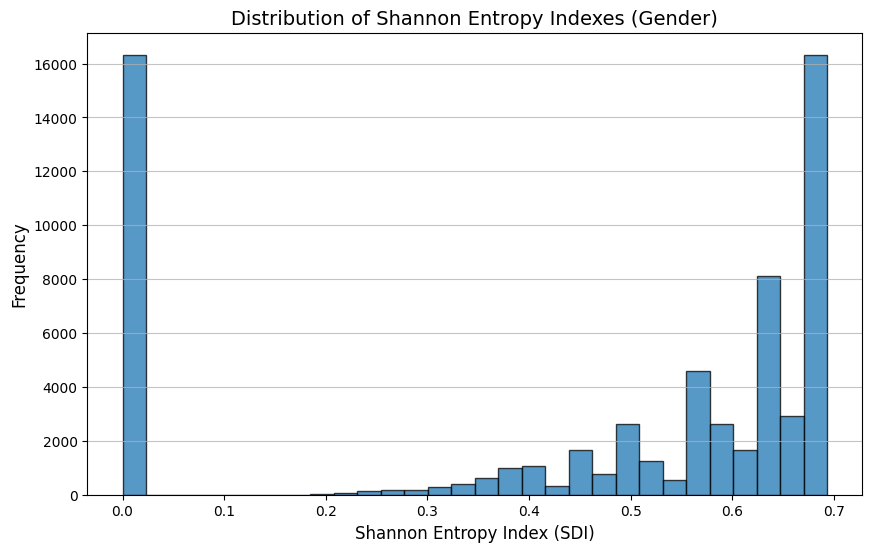

In [64]:
# Plot the distribution of Shannon entropy indexes
plt.figure(figsize=(10, 6))
plt.hist(df_gender_counts['SDI_gender'], bins=30, alpha=0.75, edgecolor='black')
plt.title('Distribution of Shannon Entropy Indexes (Gender)', fontsize=14)
plt.xlabel('Shannon Entropy Index (SDI)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.show()

The **Shannon Entropy Index (SDI)** for gender reveals moderate diversity, with many movies showing an SDI of 0, reflecting single-gender casts, often male-dominated in reality. While the mean SDI of 0.45 indicates limited gender balance, higher values around 0.6–0.7 suggest progress in representation for some films. This aligns with ongoing industry efforts to improve gender diversity, though the persistence of imbalance highlights the slow pace of change.

## Diversity Scores VS Ratings: 

Adding Diversity and gender scores to original master dataframe. 

In [65]:
# Merge SDI_ethnicity
df_movies_tmdb_ratings_unique = df_movies_tmdb_ratings_unique.merge(
    df_ethnicity_counts[['wikipedia_id', 'SDI_ethnicity']],
    on='wikipedia_id',
    how='left'
)
# Merge SDI_gender and GPR
df_movies_tmdb_ratings_unique = df_movies_tmdb_ratings_unique.merge(
    df_gender_counts[['wikipedia_id', 'SDI_gender']],
    on='wikipedia_id',
    how='left'
)

df_movies_tmdb_ratings.head() 

,wikipedia_id,freebase_id,title,release_date,revenue,runtime,spoken_languages,countries,genres,budget,imdb_id,original_language,production_companies,averageRating,numVotes,genre_count,region,missing_values,nb_actors
34316,30332673,/m/0crs0hx,#1 Cheerleader Camp,2010,NaN,90.0,None,United States of America,Comedy,None,1637976,en,The Asylum,3.7,3432,5,North America,3,15.0
34316,30332673,/m/0crs0hx,#1 Cheerleader Camp,2010,NaN,90.0,None,United States of America,Comedy,None,1637976,en,The Asylum,3.7,3432,5,North America,3,15.0
5664,4213160,/m/0bq8q8,$,1971,NaN,119.0,English Language,United States of America,Crime fiction,None,68152,en,"Worldwide, Pan, Columbia Pictures",6.3,2970,6,North America,2,9.0
5664,4213160,/m/0bq8q8,$,1971,NaN,119.0,English Language,United States of America,Action,None,68152,en,"Worldwide, Pan, Columbia Pictures",6.3,2970,6,North America,2,9.0
5664,4213160,/m/0bq8q8,$,1971,NaN,119.0,English Language,United States of America,Comedy,None,68152,en,"Worldwide, Pan, Columbia Pictures",6.3,2970,6,North America,2,9.0


In [66]:
# deleting not used dataframes (but keeping the original ones)
del df_filtered # df_characters without missing ethnicities
del df_ethnicity_exploded
del total_actors
del df_sdi


del df_characters_gender
del total_actors_per_movie
del df_sdi_gender

### 1- Ethnicity Score VS Ratings

In [67]:
df_correlation_ethnicity = df_movies_tmdb_ratings_unique[['averageRating', 'SDI_ethnicity']].dropna()

# Calculate Pearson correlation
pearson_corr, pearson_p = pearsonr(df_correlation_ethnicity['averageRating'], df_correlation_ethnicity['SDI_ethnicity'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(df_correlation_ethnicity['averageRating'], df_correlation_ethnicity['SDI_ethnicity'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")


Pearson correlation: -0.0588, p-value: 0.0000
Spearman correlation: -0.0670, p-value: 0.0000


The p-value of 0 indicates a statistically significant relationship, but the coefficients are extremely weak. This is likely due to the large size of our dataset (n=32,621 if using unique), where even trivial relationships can appear significant. 

To better assess the relationship between the ethnicity score of a movie and its average rating, we will sample the unique dataframe and explore whether this yields more meaningful insights.

In [101]:
#sampling the unique dataframe
sampled_df = df_movies_tmdb_ratings_unique[['SDI_ethnicity', 'averageRating']].dropna().sample(n=5000, random_state=42)
df_correlation_ethnicity = sampled_df[['averageRating', 'SDI_ethnicity']].dropna()

# Pearson and Spearman correlations
print("Correlation Tests:")
pearson_corr, pearson_p = pearsonr(df_correlation_ethnicity['SDI_ethnicity'], df_correlation_ethnicity['averageRating'])
spearman_corr, spearman_p = spearmanr(df_correlation_ethnicity['SDI_ethnicity'], df_correlation_ethnicity['averageRating'])
print(f"Pearson: Correlation = {pearson_corr:.4f}, p-value = {pearson_p:.4f}")
print(f"Spearman: Correlation = {spearman_corr:.4f}, p-value = {spearman_p:.4f}")

Correlation Tests:
Pearson: Correlation = -0.0373, p-value = 0.0084
Spearman: Correlation = -0.0438, p-value = 0.0019


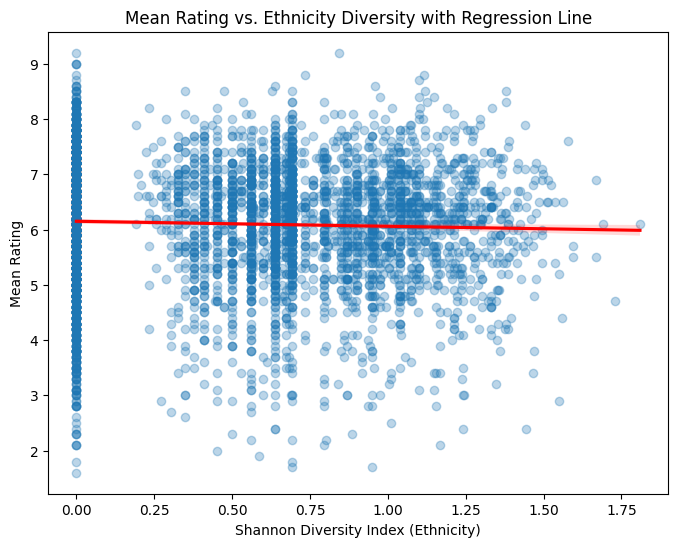

In [102]:
plt.figure(figsize=(8,6))
sns.regplot(
    x='SDI_ethnicity', 
    y='averageRating', 
    data=sampled_df, 
    scatter_kws={'alpha':0.3}, 
    line_kws={'color':'red'}
)
plt.xlabel('Shannon Diversity Index (Ethnicity)')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Ethnicity Diversity with Regression Line')
plt.show()

In [103]:
#binning ethnicity into 4 grouos to compare their mean ratings
bin_edges = [-0.01, 0.0, 0.5, 1.0, 2.0]  # bin edges
bin_labels = ["Zero", "Low", "Medium", "High"]  # 4 bins to match your labels

sampled_df['ethnicity_group'] = pd.cut(
    sampled_df['SDI_ethnicity'], 
    bins=bin_edges, 
    labels=bin_labels,
    include_lowest=True
)

# Check the distribution of the bins
print(sampled_df['ethnicity_group'].value_counts())

ethnicity_group
Zero      2168
Medium    1692
High       757
Low        383
Name: count, dtype: int64


In [104]:
# Extract ratings for each group
group_zero = sampled_df[sampled_df['ethnicity_group'] == 'Zero']['averageRating']
group_low = sampled_df[sampled_df['ethnicity_group'] == 'Low']['averageRating']
group_medium = sampled_df[sampled_df['ethnicity_group'] == 'Medium']['averageRating']
group_high = sampled_df[sampled_df['ethnicity_group'] == 'High']['averageRating']

# ANOVA
stat_anova, p_anova = f_oneway(group_zero, group_low, group_medium, group_high)
print(f"ANOVA p-value: {p_anova:.4f}")


ANOVA p-value: 0.0303


/var/folders/zw/3d22h42x67lctzjb8rx_3bdm0000gn/T/ipykernel_38432/3135979298.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([group_zero, group_low, group_medium, group_high], labels=["Zero", "Low", "Medium", "High"])


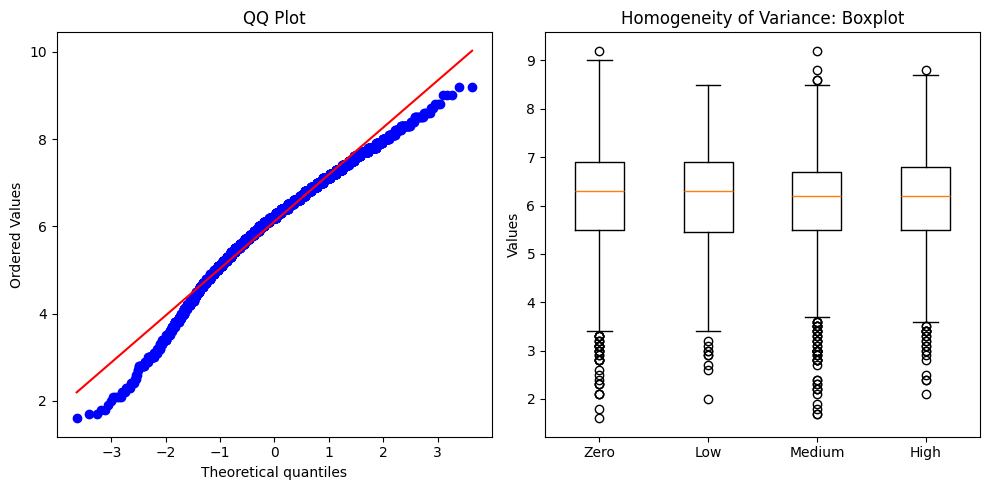

In [109]:

#Combine all groups for QQ plot
data_combined = np.concatenate([group_zero, group_low, group_medium, group_high])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# QQ Plot
stats.probplot(data_combined, dist="norm", plot=axes[0])
axes[0].set_title("QQ Plot")

# Boxplot for variance visualization
axes[1].boxplot([group_zero, group_low, group_medium, group_high], labels=["Zero", "Low", "Medium", "High"])
axes[1].set_title("Homogeneity of Variance: Boxplot")
axes[1].set_ylabel("Values")

plt.tight_layout()
plt.show()

The null hypothesis for ANOVA states that the mean ratings across all four ethnicity groups ("Zero," "Low," "Medium," "High") are equal. Since the p-value is less than 0.05, we reject the null hypothesis and conclude that there is a significant difference in mean ratings among at least one of the groups.

In [74]:
del sampled_df

## Gender Score VS Ratings

Same approach to the genre score as for the diversity score. 

In [110]:
df_correlation_gender = df_movies_tmdb_ratings_unique[['averageRating', 'SDI_gender']].dropna()

# Calculate Pearson correlation
pearson_corr, pearson_p = pearsonr(df_correlation_gender['averageRating'], df_correlation_gender['SDI_gender'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(df_correlation_gender['averageRating'], df_correlation_gender['SDI_gender'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

Pearson correlation: -0.0455, p-value: 0.0000
Spearman correlation: -0.0442, p-value: 0.0000


We try with the sampled dataframe here also to make sure of the viability of our results.

In [111]:
sampled_df = df_movies_tmdb_ratings_unique[['SDI_gender', 'averageRating']].dropna().sample(n=5000, random_state=42)
df_correlation_gender = sampled_df[['averageRating', 'SDI_gender']].dropna()

# Calculate Pearson correlation
pearson_corr, pearson_p = pearsonr(df_correlation_gender['averageRating'], df_correlation_gender['SDI_gender'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# Calculate Spearman correlation
spearman_corr, spearman_p = spearmanr(df_correlation_gender['averageRating'], df_correlation_gender['SDI_gender'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")

Pearson correlation: -0.0402, p-value: 0.0045
Spearman correlation: -0.0352, p-value: 0.0129


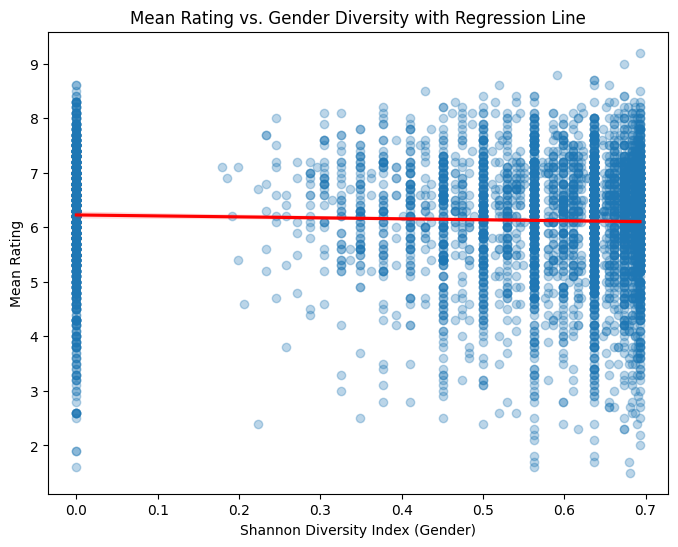

In [112]:
plt.figure(figsize=(8,6))
sns.regplot(
    x='SDI_gender', 
    y='averageRating', 
    data=sampled_df, 
    scatter_kws={'alpha':0.3}, 
    line_kws={'color':'red'}
)
plt.xlabel('Shannon Diversity Index (Gender)')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Gender Diversity with Regression Line')
plt.show()

In [113]:
# Splitting SDI_genders into two groups
group_low = df_correlation_gender[df_correlation_gender['SDI_gender'] <= 0.5]['averageRating']
group_high = df_correlation_gender[df_correlation_gender['SDI_gender'] > 0.5]['averageRating']

# Perform ANOVA assuming normality of distribution of ratings 
f_stat, p_anova = f_oneway(group_low, group_high)
print(f"ANOVA p-value: {p_anova:.4f}")

ANOVA p-value: 0.0071


/var/folders/zw/3d22h42x67lctzjb8rx_3bdm0000gn/T/ipykernel_38432/2198202424.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([group_zero, group_low, group_medium, group_high], labels=["Zero", "Low", "Medium", "High"])


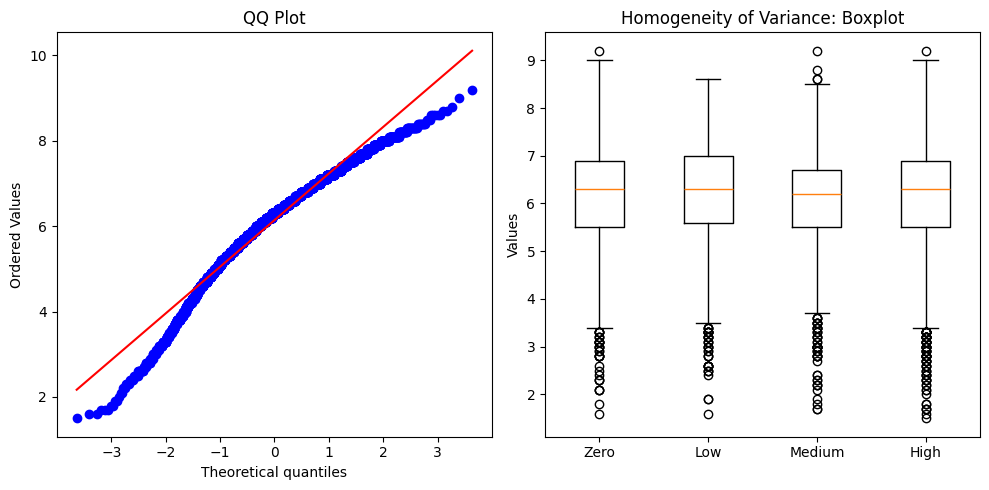

In [114]:
from scipy.stats import levene
#Combine all groups for QQ plot
data_combined = np.concatenate([ group_low ,group_high])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# QQ Plot
stats.probplot(data_combined, dist="norm", plot=axes[0])
axes[0].set_title("QQ Plot")

# Boxplot for variance visualization
axes[1].boxplot([group_zero, group_low, group_medium, group_high], labels=["Zero", "Low", "Medium", "High"])
axes[1].set_title("Homogeneity of Variance: Boxplot")
axes[1].set_ylabel("Values")

plt.tight_layout()
plt.show()

In [79]:
del sampled_df 

# Spoken Languages in movies: 

Another factor that can reflect a movie's **diversity and global appeal** is the **number of spoken languages** featured in it. Analyzing this can provide insights into how linguistic diversity might influence audience ratings.

In [80]:
# Explode the languages column so each language gets its own row
df_languages_exploded = df_movies_tmdb_ratings_unique.explode('spoken_languages')
# Group by language and calculate the mean rating
mean_rating_per_language = df_languages_exploded.groupby('spoken_languages')['averageRating'].mean().reset_index()
# Sort by rating to see the most and least impactful languages
mean_rating_per_language = mean_rating_per_language.sort_values(by='averageRating', ascending=False)
print(mean_rating_per_language.head())

                                      spoken_languages  averageRating
486  Latin Language,Italian Language,Sicilian Langu...            9.2
307                                           Hariyani            9.2
243  French Language,Polish Language,Hebrew Languag...            9.0
406  Italian Language,English Language,Latin Langua...            9.0
202  French Language,Hebrew Language,Yiddish Langua...            8.7


In [81]:
#We add filter empty lists of spoken languages and drop na_s and see if the nb of spoken languages 
#is correlated to the mean rating
#Drop rows where spoken_languages is NaN
df_movies_with_languages = df_movies_tmdb_ratings_unique.dropna(subset=['spoken_languages'])
# Drop rows where spoken_languages is an empty list
df_movies_with_languages = df_movies_with_languages[
    df_movies_with_languages['spoken_languages'].apply(lambda x: len(x) > 0)
]
# Check the resulting dataframe
print(df_movies_with_languages[['wikipedia_id', 'spoken_languages']].head())

   wikipedia_id                                  spoken_languages
1       4213160                                  English Language
2      10331139                                  English Language
3      13504095                      Silent film,English Language
4       3610422                                  English Language
5      16038391  French Language,English Language,German Language


In [82]:
# Count the number of languages per movie
df_movies_with_languages['nb_languages'] = df_movies_with_languages['spoken_languages'].apply(len)
# Check the updated dataframe
print(df_movies_with_languages[['wikipedia_id', 'averageRating', 'nb_languages']].head())

   wikipedia_id  averageRating  nb_languages
1       4213160            6.3            16
2      10331139            5.4            16
3      13504095            3.3            28
4       3610422            5.0            16
5      16038391            6.7            48


In [83]:
# Drop rows with missing values in 'mean_rating' or 'nb_languages'
df_correlation_languages = df_movies_with_languages.dropna(subset=['averageRating', 'nb_languages'])
# Pearson correlation
pearson_corr, pearson_p = pearsonr(df_correlation_languages['nb_languages'], df_correlation_languages['averageRating'])
print(f"Pearson correlation: {pearson_corr:.4f}, p-value: {pearson_p:.4f}")

# Spearman correlation
spearman_corr, spearman_p = spearmanr(df_correlation_languages['nb_languages'], df_correlation_languages['averageRating'])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {spearman_p:.4f}")


Pearson correlation: 0.0969, p-value: 0.0000
Spearman correlation: 0.0750, p-value: 0.0000


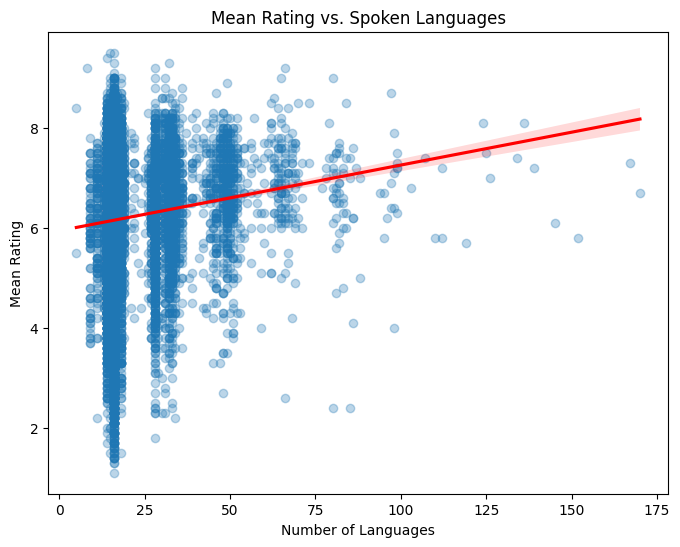

In [84]:
plt.figure(figsize=(8,6))
sns.regplot(
    x='nb_languages', 
    y='averageRating', 
    data=df_correlation_languages, 
    scatter_kws={'alpha':0.3}, 
    line_kws={'color':'red'}
)
plt.xlabel('Number of Languages')
plt.ylabel('Mean Rating')
plt.title('Mean Rating vs. Spoken Languages')
plt.show()

In [87]:
# Splitting nb_languages into two groups
group_low = df_correlation_languages[df_correlation_languages['nb_languages'] <= 15]['averageRating']
group_high = df_correlation_languages[df_correlation_languages['nb_languages'] > 15]['averageRating']


In [88]:
# Perform ANOVA assuming normality of distribution of ratings 
f_stat, p_anova = f_oneway(group_low, group_high)
print(f"ANOVA p-value: {p_anova:.4f}")

ANOVA p-value: 0.0202


/var/folders/zw/3d22h42x67lctzjb8rx_3bdm0000gn/T/ipykernel_38432/1791711648.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([group_zero, group_low, group_medium, group_high], labels=["Zero", "Low", "Medium", "High"])


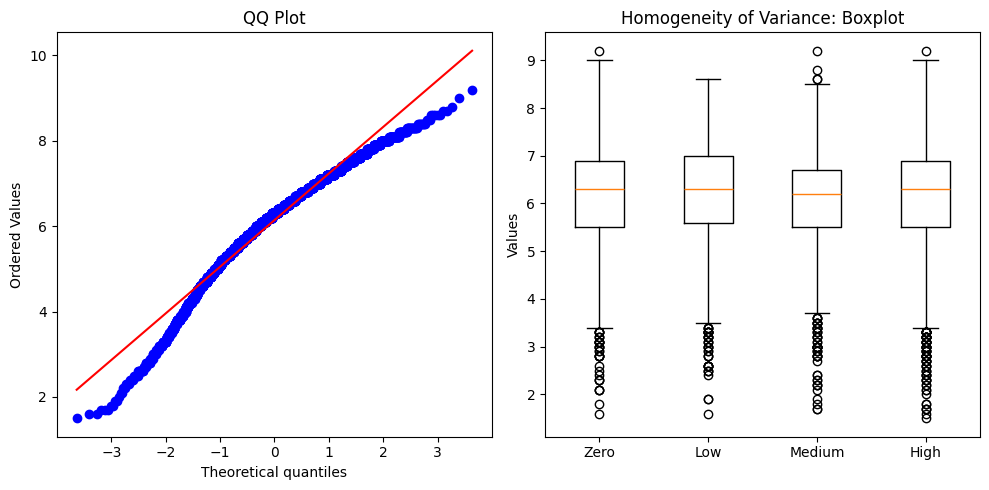

In [115]:

#Combine all groups for QQ plot
data_combined = np.concatenate([ group_low ,group_high])

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# QQ Plot
stats.probplot(data_combined, dist="norm", plot=axes[0])
axes[0].set_title("QQ Plot")

# Boxplot for variance visualization
axes[1].boxplot([group_zero, group_low, group_medium, group_high], labels=["Zero", "Low", "Medium", "High"])
axes[1].set_title("Homogeneity of Variance: Boxplot")
axes[1].set_ylabel("Values")

plt.tight_layout()
plt.show()
